# DÖNTÉSI FA ÉS KLASSZIFIKÁCIUÓS MODELL ÉRTÉKELÉS 

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrixot

from collections import Counter
import seaborn as sns
from sklearn.linear_model import LogisticRegression

import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from IPython.display import Image
from IPython.core.display import HTML 

import scikitplot as skplt
from sklearn.metrics import auc
from sklearn.metrics import f1_score

from sklearn import tree
import graphviz
from dtreeviz.trees import dtreeviz # remember to load the package

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from numpy import where
from tqdm import tqdm_notebook as tqdm

# START

- Supervised learning 
- Nem lineáris kapcsolatok vizsgálatára tökéletes 
- Regresszióra (mse, mae) és klasszifikációra (gini, entropy) is jó 
- Intuitív, egyszerűen értelmezhető
- Semmire se jó magában (bagging és boosting következő óra)

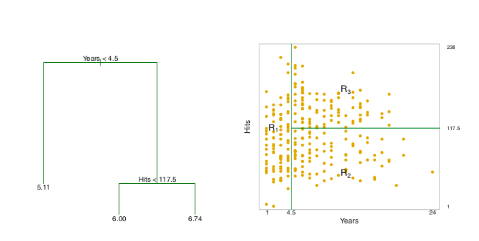

In [2]:
Image(filename='Screenshot from 2020-10-21 13-21-21.png') 

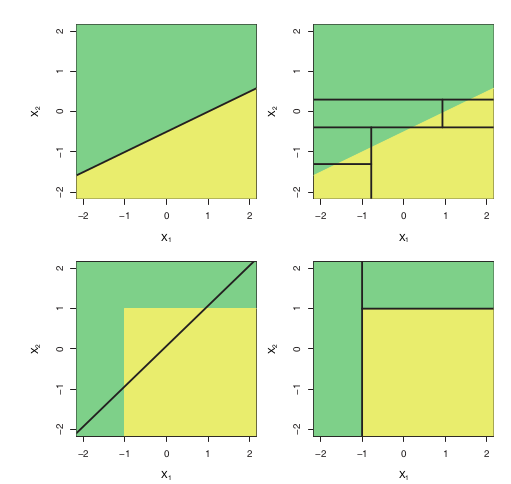

In [3]:
Image(filename='dtree_vs_lin.png') 

In [4]:
def draw_conf_matrix(test,pred):
    
    cf_matrix = confusion_matrix(test, pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #plt.figure(figsize=(7,7))
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xlabel("Pred")
    ax.set_ylabel("True")

    #plt.show()
    
    
def draw_roc_curve(model, X_test ,y_test):
    
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()
    
    
def draw_prec_recall(model,testX, testy):
    
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(testX)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print('model: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    #plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
def ecl_eval(true,pred): 
    
    if true == 1 and pred == 1:
        return "TP"
        
    if true == 0 and pred == 0:
        return "TN"
        
    if true == 1 and pred == 0:
        return "FN"
        
    if true == 0 and pred == 1:
        return "FP"
    
def age_group(x):
    
    """if x < 50:
        return "50 alatt"
    elif 50<x<60:
        return "50-60"
    elif 60<x:
        return "60 felett"
    """
    
    if x < 55:
        return "55 alatt"
    else:
        return "55 felett"

# Import Data

In [5]:
data = pd.read_csv("processed.cleveland.data", header=None)

#https://archive.ics.uci.edu/ml/datasets/heart+disease

In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


- age: Float
- sex: Category
    - 0 female
    - 1 
- cp / chest pain, Cat
    - 1: typical angina
    - 2: atypical angina
    - 3: non-anginal pain
    - 4: asympltomatic
- restbp / resting blood pressure, Float
- chol / cholesterol Float
- fbs / fasting blood sugar, Cat
    - 0 >= 120 mg/dl
    - 1 <=
- restecg / resting electricardiographical result, Cat
    - 1 normal
    - 2 having ST-T wave abnormality
    - 3 showing probable or definite left venticular hypertrophy
- thalach / maximum heart rate achived, Float
- exang / exercise induced angina, Category
    - 0 No
    - 1 Yes
- oldpeak / ST depressiom induced by exercise relative to rest, Float
- slpoe / slope of peak exercise ST segment, Cat
    - 1 upsloping
    - 2 flat
    - 3  downsloping
- ca / number of major vessels (0-3) colored by fluoroscopy, Float
- thal / thalium hearth scan, Cat
    - 3 normal
    - 6 fixed defect
    - 7 reversible defect

In [7]:
cols = ["age",
        "sex",
        "cp",
        "trestbps",
        "chol",
        "fbs",
        "restecg",
        "thalach",
        "exang",
        "oldpeak",
        "slope",
        "ca",
        "thal",
        "hd",]

In [8]:
data.columns = cols

In [9]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# Missing data

- Remove
- Impute

In [10]:
data.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
hd            int64
dtype: object

In [11]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
hd          0
dtype: int64

In [12]:
data.thal.unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

In [13]:
Counter(data.thal)

Counter({'6.0': 18, '3.0': 166, '7.0': 117, '?': 2})

In [14]:
data.replace("?",pd.np.nan).isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
hd          0
dtype: int64

In [15]:
data.loc[(data.thal == "?") | (data.ca == "?") ]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [16]:
data_nm = data.loc[(data.thal != "?") & (data.ca != "?") ].copy()

In [17]:
data_nm

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


# Visualizations 

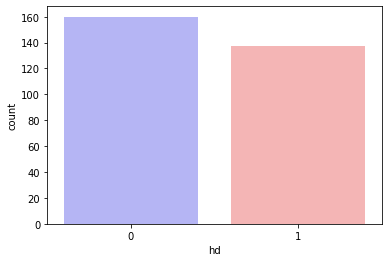

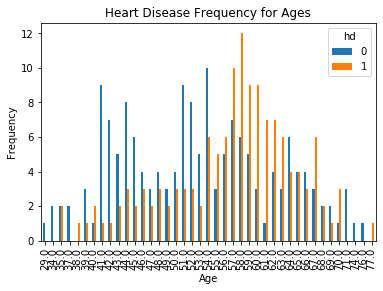

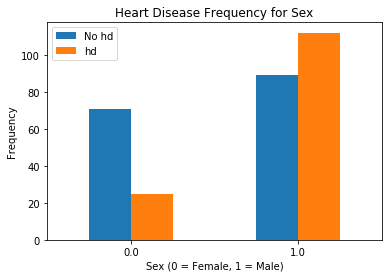

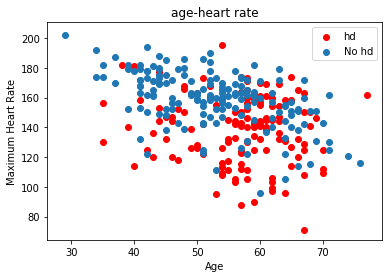

In [18]:
vis_data = data_nm.copy()
vis_data["hd"] = vis_data.hd.apply(lambda x: 0 if x== 0 else 1)

"""f,ax= plt.subplots(figsize=(7,7))
sns.heatmap(vis_data.corr(), annot=True, linewidths=.5, fmt=".1f",ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()"""

sns.countplot(x="hd", data=vis_data, palette="bwr")
plt.show()

pd.crosstab(vis_data.age,vis_data.hd).plot(kind="bar")
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('heartDiseaseAndAges.png')
plt.show()

pd.crosstab(vis_data.sex,vis_data.hd).plot(kind="bar")
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["No hd", "hd"])
plt.ylabel('Frequency')
plt.show()

plt.scatter(x=vis_data.age[vis_data.hd==1], y=vis_data.thalach[(vis_data.hd==1)], c="red")
plt.scatter(x=vis_data.age[vis_data.hd==0], y=vis_data.thalach[(vis_data.hd==0)])
plt.legend(["hd", "No hd"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.title("age-heart rate")
plt.show()

# Split data to dep and indept

In [19]:
X = data_nm.drop("hd",axis=1)

In [20]:
y = data_nm.hd

In [21]:
Counter(y)

Counter({0: 160, 2: 35, 1: 54, 3: 35, 4: 13})

In [22]:
X.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [23]:
X_encoded = pd.get_dummies(X, columns=["cp","restecg","slope","thal"])

In [24]:
y = y.apply(lambda x: 0 if x== 0 else 1)

In [25]:
Counter(y)

Counter({0: 160, 1: 137})

In [26]:
X_encoded

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,140.0,241.0,0.0,123.0,1.0,0.2,0.0,0,...,1,1,0,0,0,1,0,0,0,1
298,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,0.0,1,...,0,1,0,0,0,1,0,0,0,1
299,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,2.0,0,...,1,1,0,0,0,1,0,0,0,1
300,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1.0,0,...,1,1,0,0,0,1,0,0,0,1


# Build tree

https://scikit-learn.org/stable/modules/tree.html

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X_encoded.applymap(float), y, test_size = 0.4,random_state = 42, )

In [28]:
clf_dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

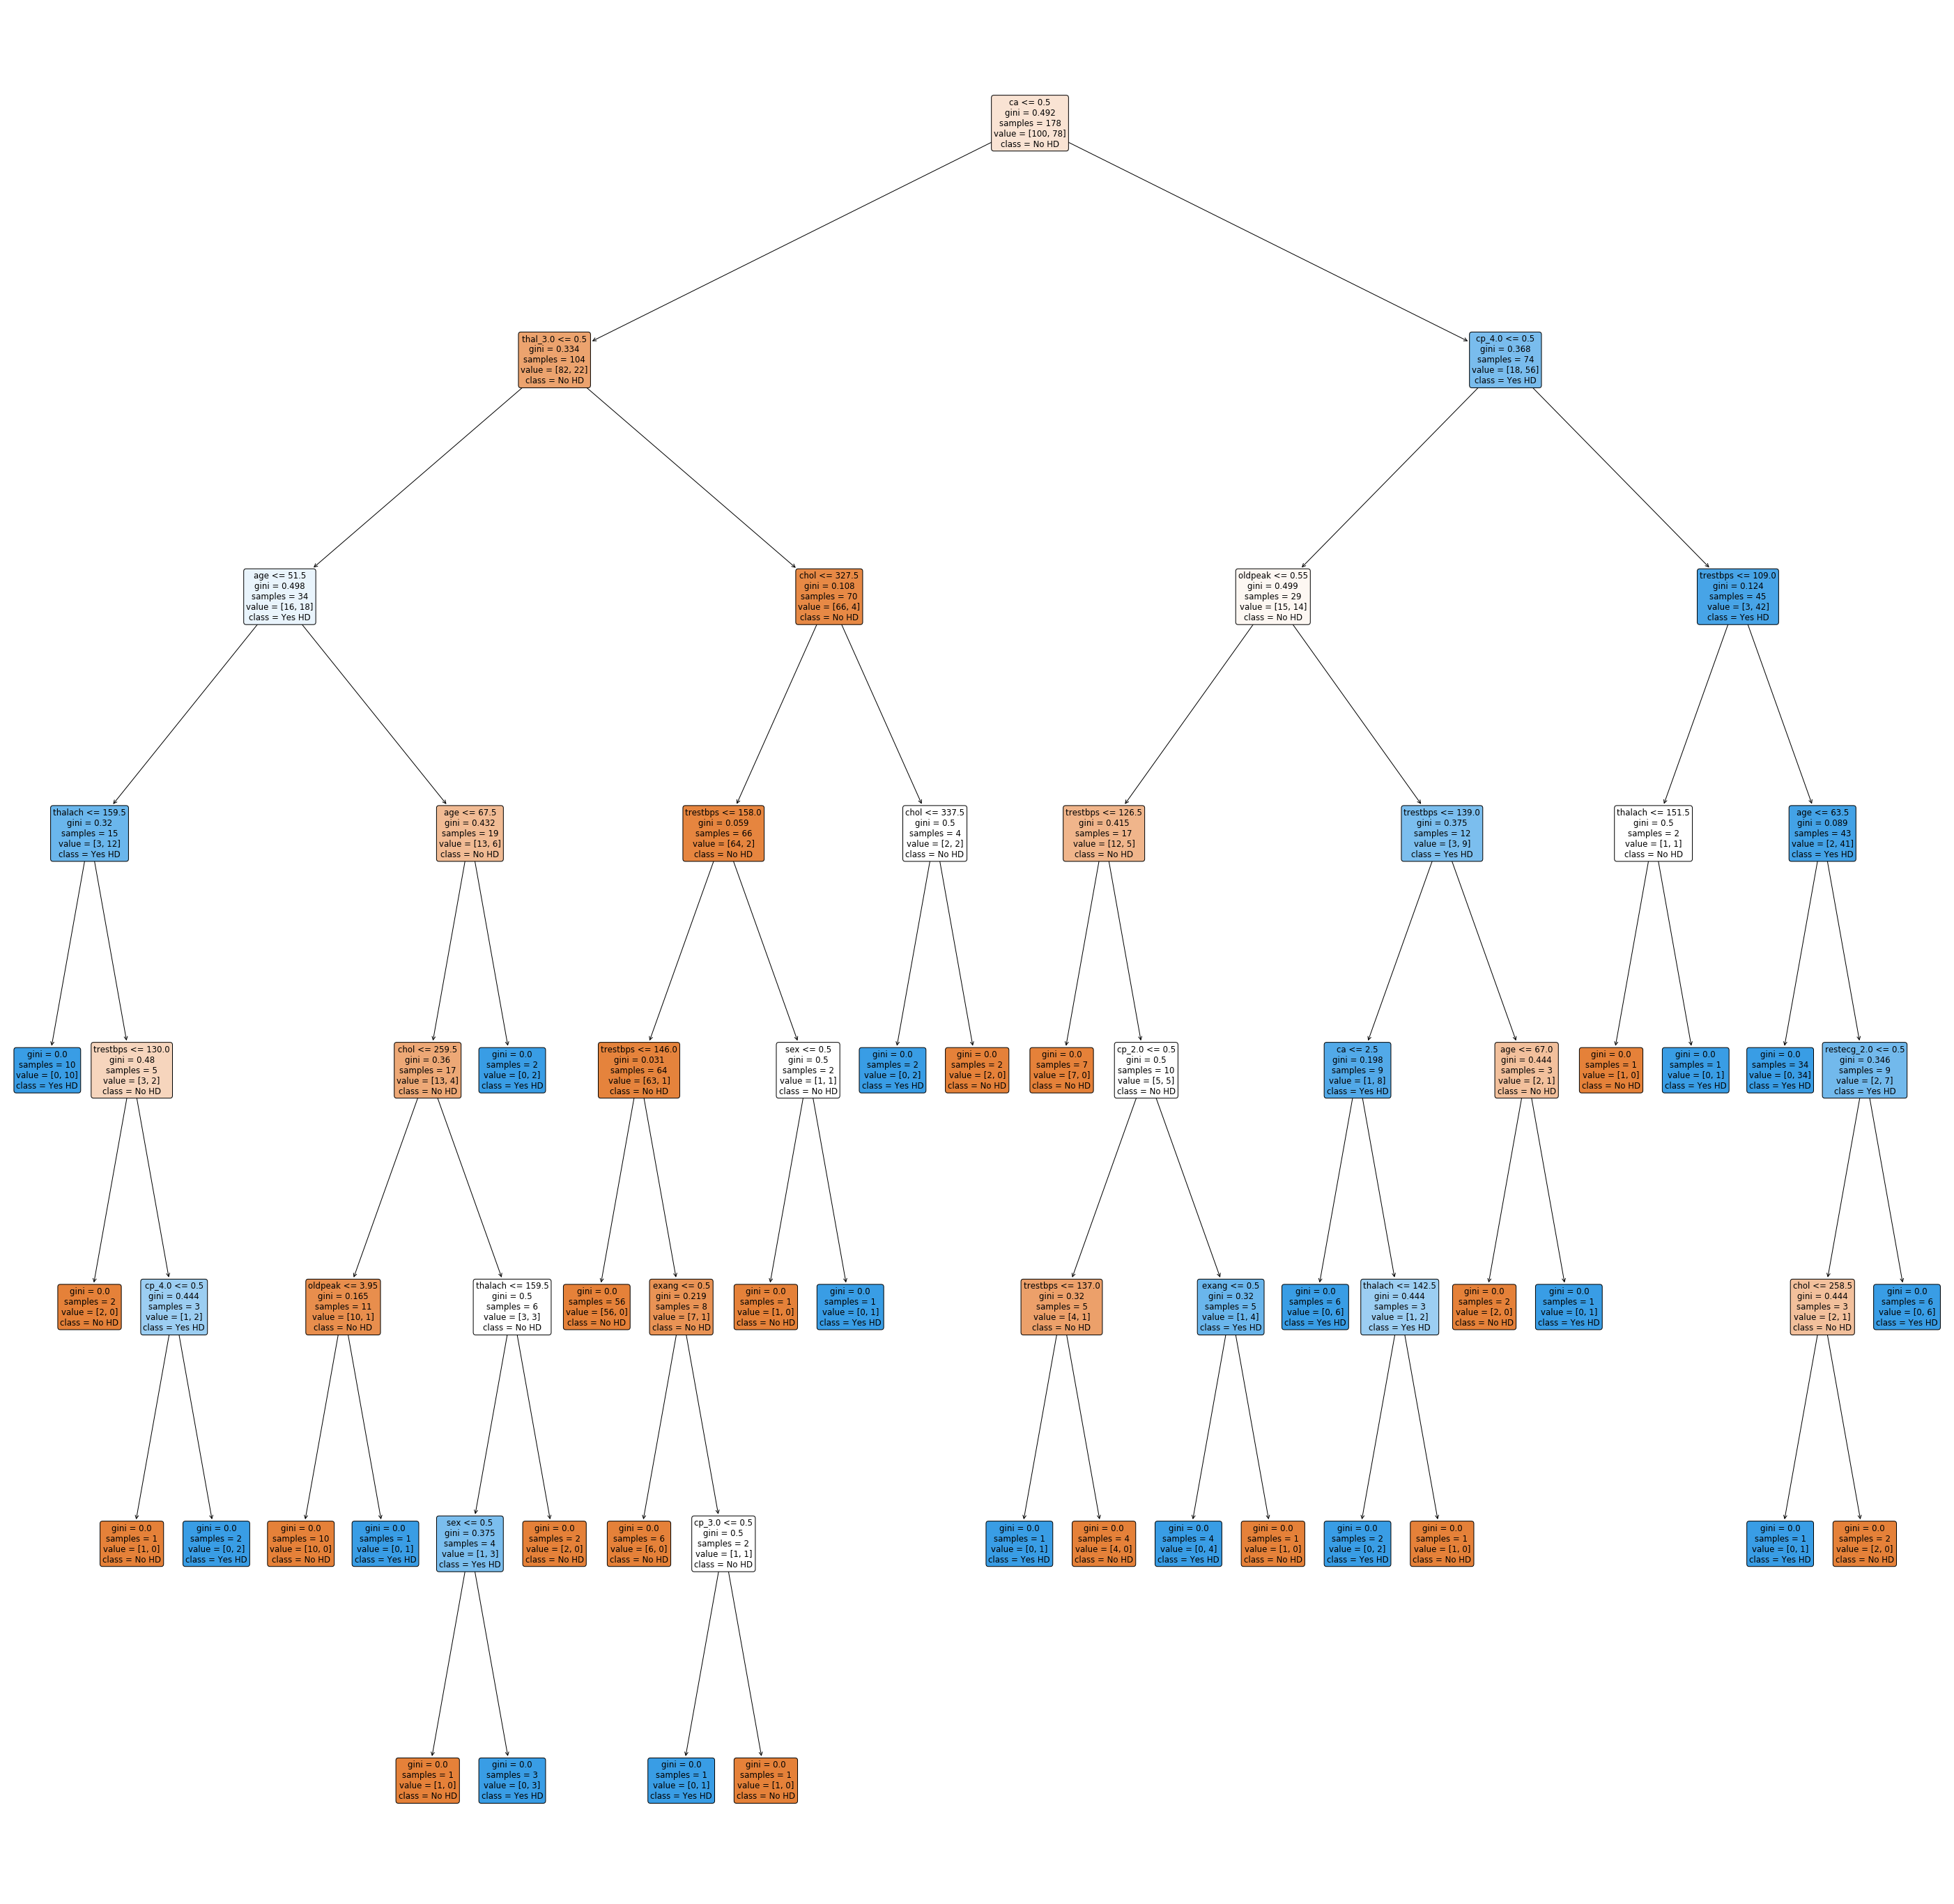

In [29]:
plt.figure(figsize=(50,50))
plot_tree(clf_dt
         ,filled=True
         ,rounded=True
         ,class_names=["No HD","Yes HD"]
         ,feature_names=X_encoded.columns)
#plt.savefig('big_tree.jpg')

### ELŐNYÖK

- Egyszerűen értelmezhető (White box)
- Nem kell bonbyolódni az adattal (normalizáció, dummyk, missing values)
- Gyors
- Numerical és categórikus értékekekt is tud kezelni 

### HÁTRÁNYOK
- Túltanulás, túl bonyolult fákat épít 
- Unstable - kis váltoizás az adatban teljesen más fát eredményezhet
- Bias alakulhat ki, ha nagyon imbalanced a minta


### FŐBB PARAMÉTEREK

Alapvetően a döntési fákkal a legnagyobb probléma az, hogy nagyon könnyen overfittelnek, ezért a legtöbb paramétere az algoritmusnak ezt törekszik csökkenteni. 

- criterion: string, optional (default=”gini”) or entropy
- splitter: string, optional (default=”best”)
    - best: legjobb, lassabb 
    - random: random feature selection, kevésbé overfittel
- max_depth: int or None, optional (default=None)
    - maximális mélység: minden adatpont 1 leaf
    - alapból addig megy, amíg tiszta nem lesz minden leaf
- min_samples_split: int, float, optional (default=2)
    - mennyi megfigyelésnek kell lennie egy splithez 
- min_samples_leaf: int, float, optional (default=1)
    - mennyi megfigyelésnek kell lennie egy levélen legalább a split után 
- max_features: int, float, string or None, optional (default=None)
    - hány feature közül válasszon az algoritmus, mikor a legjobb splitet keresi 
- min_impurity_decrease: float, optional (default=0.)
    - N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)
    - N, N_t, N_t_R and N_t_L all refer to the weighted sum
    - weight * (the number of samples from a class in the node) / (size of class)
    - 0 gini index = pure leaf 
    - meg kell nézni a plotot, hogy mi az utolsó pure vágás előtti gini és dönteni, hogy kell-e nekem a pure leaf
- class_weight: dict, list of dicts, “balanced” or None, default=None
    - egy súlyt ad az output classoknak 
    - imbalanced data esetén hasznos 



https://scikit-learn.org/stable/modules/tree.html

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

# Cost complexity pruning 

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#:~:text=Cost%20complexity%20pruning%20provides%20another,the%20number%20of%20nodes%20pruned.

In [30]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)

In [31]:
ccp_alphas = path.ccp_alphas

In [32]:
ccp_alphas = ccp_alphas[:-1]

In [33]:
ccp_alphas

array([0.        , 0.0036868 , 0.00499376, 0.00536527, 0.00561798,
       0.00646067, 0.00674157, 0.00749064, 0.00780275, 0.00842697,
       0.00875744, 0.00898876, 0.00898876, 0.01011236, 0.01029233,
       0.01156642, 0.01175775, 0.01348315, 0.0164266 , 0.0220823 ,
       0.04022744, 0.05734985])

In [34]:
clf_dt_list = [DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X_train, y_train) for ccp_alpha in ccp_alphas]

In [35]:
train_score = [clf_dt.score(X_train, y_train) for clf_dt in clf_dt_list]

In [36]:
test_score = [clf_dt.score(X_test, y_test) for clf_dt in clf_dt_list]

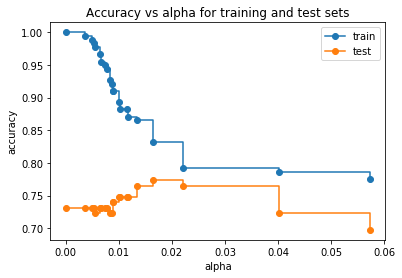

In [37]:
fig,ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and test sets")
ax.plot(ccp_alphas, train_score, marker = "o", label = "train", drawstyle = "steps-post")
ax.plot(ccp_alphas, test_score, marker = "o", label = "test", drawstyle = "steps-post")
ax.legend()
plt.show()

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

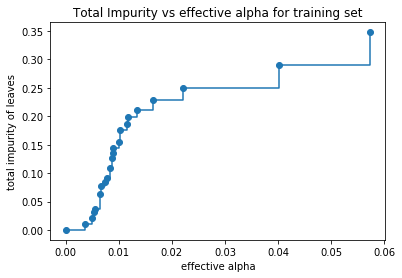

In [38]:
impurities = path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Number of nodes in the last tree is: 3 with ccp_alpha: 0.057349854375631004


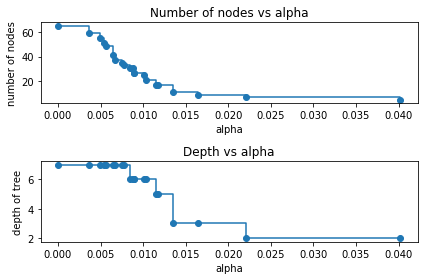

In [39]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))


clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

# CCP CV for finding best alpha 

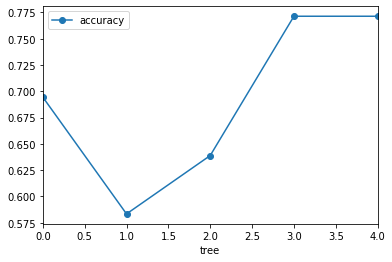

In [40]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016)
scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)
df = pd.DataFrame (data={"tree":range(5), "accuracy":scores})
df.plot(x='tree', marker = 'o', )

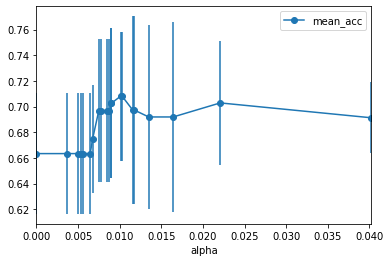

In [41]:
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)
    alpha_loop_values.append([ccp_alpha,np.mean(scores),np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values, columns= ['alpha',"mean_acc","std"])

alpha_results.plot(x="alpha"
                  ,y="mean_acc"
                  ,yerr="std"
                  ,marker="o")

In [42]:
alpha_results.loc[(alpha_results.alpha > 0.014) & (alpha_results.alpha < 0.015)]

,alpha,mean_acc,std


In [43]:
alpha_results.loc[(alpha_results.alpha > 0.014) & (alpha_results.alpha < 0.015)].alpha

Series([], Name: alpha, dtype: float64)

In [44]:
best_a = alpha_results.loc[alpha_results.mean_acc == alpha_results.mean_acc.max()].alpha.unique().max()

In [45]:
best_a

0.010292329393452988

# Building, evaluating, Drawing and Interpreting the final class tree

https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/#:~:text=A%20confusion%20matrix%20is%20a,related%20terminology%20can%20be%20confusing.

https://www.dataschool.io/roc-curves-and-auc-explained/

https://en.wikipedia.org/wiki/Confusion_matrix



In [46]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha = best_a)
model = clf_dt_pruned.fit(X_train,y_train)


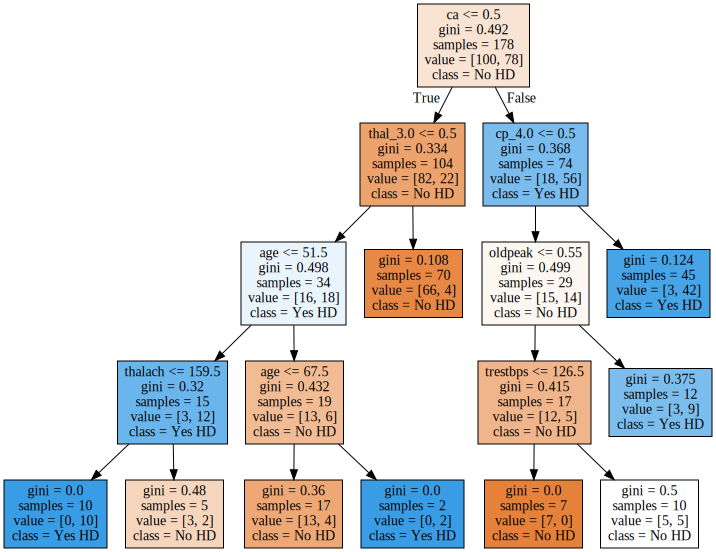

In [47]:
# DOT data
dot_data = tree.export_graphviz(clf_dt_pruned, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=["No HD","Yes HD"],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


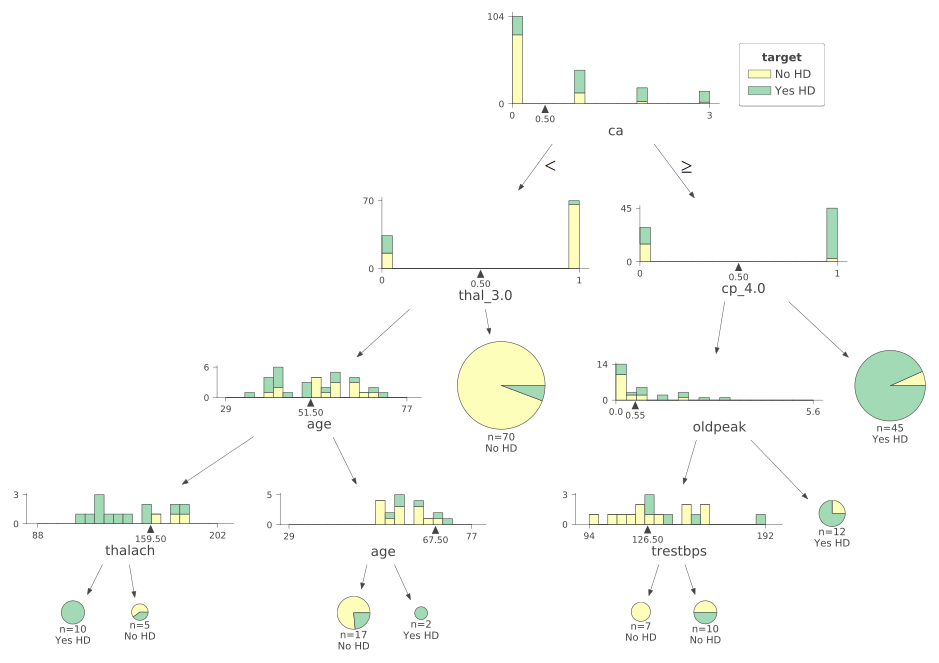

In [48]:
# https://mljar.com/blog/visualize-decision-tree/

plot = dtreeviz(clf_dt_pruned, X_train, y_train,
                target_name="target",
                feature_names=X_train.columns,
                class_names=["No HD","Yes HD"],
                scale = 1.5
                )

#plot.save("viz.svg") 

plot

# MODEL EVALUATION 

In [49]:
Image(url='https://skappal7.files.wordpress.com/2018/08/confusion-matrix.jpg')

In [50]:
Image(url= "https://i2.wp.com/neptune.ai/wp-content/uploads/acc_eq.png?fit=422%2C84&ssl=1")

In [51]:
Image(url= "https://miro.medium.com/max/355/1*HgxNKuUwXk9JHYBCt_KZNw.png")

In [52]:
Image(url='https://miro.medium.com/max/246/1*f7NmMcQtfes1ng7jtjNtHQ.png')

In [53]:
Image(url= "https://miro.medium.com/max/245/1*3GhDfiuhvINF5-9eL8g6Pw.png")

In [54]:
Image(url= "https://miro.medium.com/max/249/1*QRIZDkk_FffXKs_07ZlhZw.png")

In [55]:
Image(url= "https://miro.medium.com/max/358/1*98FaAKfPWo-EBTbjsxm4GA.png")

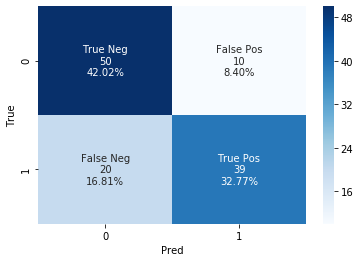

In [56]:
#Generate predictions with the model using our X values
y_pred = clf_dt_pruned.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

draw_conf_matrix(y_test, y_pred)

plt.show()

In [57]:
analyse = pd.concat([X_test,y_test], axis = 1).pipe(lambda df: df.assign(pred = y_pred))
analyse["EVAL"] = [ecl_eval(x,y) for x,y in zip(analyse.hd, analyse.pred)]
analyse["age_group"] = analyse.age.apply(age_group)

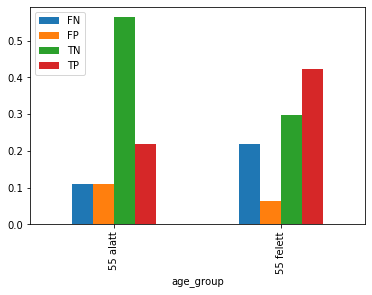

In [58]:
pivot_1 = analyse.groupby(["age_group","EVAL"]).size().reset_index().rename(columns={0:"size"}).pivot(index='age_group', columns='EVAL', values='size')

pivot_1["row_sum"] = pivot_1.sum(axis=1).values

pivot_1.columns = ["FN","FP","TN","TP","row_sum"]

pivot_1.loc[:,"FN":"TP"].div(pivot_1["row_sum"], axis=0).plot(kind='bar')

In [59]:
pivot_1

,FN,FP,TN,TP,row_sum
age_group,,,,,
55 alatt,6,6,31,12,55
55 felett,14,4,19,27,64


## Példák

- covidos kollégista
- rákszűrés 
- véradás 
- hitelkihelyzés
- börtönbüntetés
- PARKL


### CLASS WEIGHT

https://datascience.stackexchange.com/questions/56250/how-does-class-weight-work-in-decision-tree

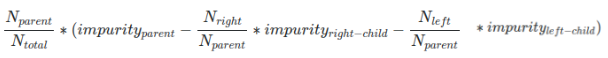

In [60]:
Image(filename='imp_measure_2.png') 

- N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)
- N, N_t, N_t_R and N_t_L all refer to the weighted sum
- weight * (the number of samples from a class in the node) / (size of class)

### ROC
- TPR(recall) / FPR
- Balanced data // az FPR-t lehúzza a nagyon sok TN
- probability ranking // melyik a valószínűbb opció
- akkor használd ha ugyan olyan fontos a pozitív és a negatív classok (pl kutya vagy macska van a képen)

### PR 
- precision, recall 
- Imbalanced data
- Amikor jobban érdekel minket a pozitív mint a negatív class / hitelezés 



https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc#1
    
https://www.kaggle.com/general/7517

AUC, NO class_weight 0.7471751412429378
ACC, NO class_weight 0.7478991596638656
model: f1=0.722 auc=0.751
AUC, weight 0.1 0.6444915254237288
ACC, weight 0.1 0.6470588235294118
model: f1=0.488 auc=0.767
AUC, class_weight 10 0.7240112994350283
ACC, class_weight 10 0.7226890756302521
model: f1=0.759 auc=0.788


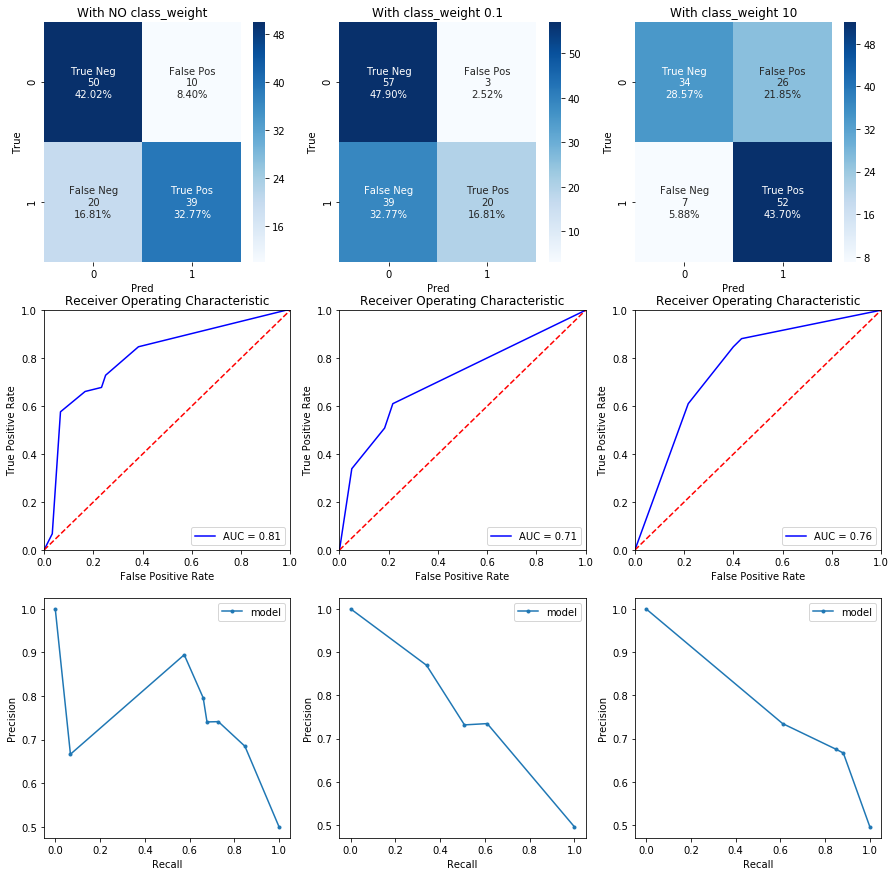

In [61]:
plt.figure(figsize=(15,15))

plt.subplot(3, 3, 1)
plt.title("With NO class_weight")
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha = best_a)
model = clf_dt_pruned.fit(X_train,y_train)
y_pred = clf_dt_pruned.predict(X_test)
draw_conf_matrix(y_test, y_pred)
print("AUC, NO class_weight",roc_auc_score(y_test, y_pred))
print("ACC, NO class_weight",accuracy_score(y_test, y_pred))

plt.subplot(3, 3, 4)
draw_roc_curve(clf_dt_pruned,X_test ,y_test)
plt.subplot(3, 3, 7)
draw_prec_recall(clf_dt_pruned,X_test ,y_test)

plt.subplot(3, 3, 2)
plt.title("With class_weight 0.1")
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha = best_a, class_weight={0:1, 1:0.1})
model = clf_dt_pruned.fit(X_train,y_train)
y_pred = clf_dt_pruned.predict(X_test)
draw_conf_matrix(y_test, y_pred)
print("AUC, weight 0.1",roc_auc_score(y_test, y_pred))
print("ACC, weight 0.1",accuracy_score(y_test, y_pred))

plt.subplot(3, 3, 5)
draw_roc_curve(clf_dt_pruned,X_test ,y_test)
plt.subplot(3, 3, 8)
draw_prec_recall(clf_dt_pruned,X_test ,y_test)

plt.subplot(3, 3, 3)
plt.title("With class_weight 10")
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha = best_a, class_weight={0:1, 1:10})
model = clf_dt_pruned.fit(X_train,y_train)
y_pred = clf_dt_pruned.predict(X_test)
draw_conf_matrix(y_test, y_pred)
print("AUC, class_weight 10",roc_auc_score(y_test, y_pred))
print("ACC, class_weight 10",accuracy_score(y_test, y_pred))      

plt.subplot(3, 3, 6)
draw_roc_curve(clf_dt_pruned,X_test ,y_test)

plt.subplot(3, 3, 9)
draw_prec_recall(clf_dt_pruned,X_test ,y_test)


/home/gabor/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


model: f1=0.788 auc=0.915
model: f1=0.759 auc=0.788


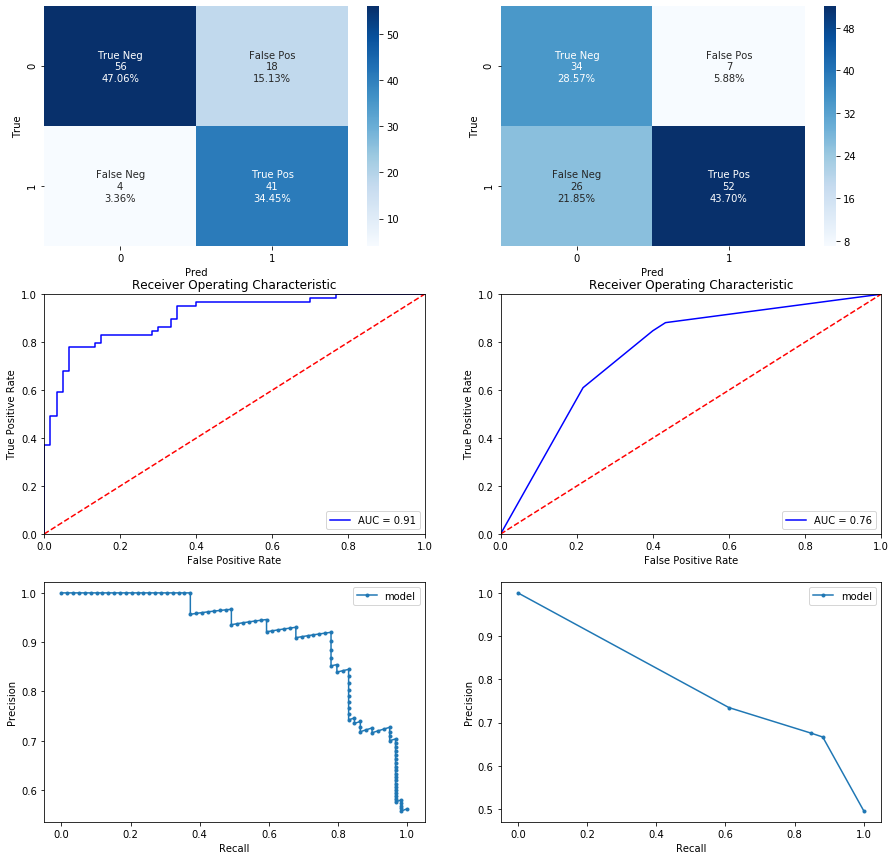

In [62]:
#Fit the model
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
#Generate predictions with the model using our X values
y_pred = logreg.predict(X_test)


plt.figure(figsize=(15,15))

plt.subplot(3, 2, 1)
draw_conf_matrix(logreg.predict(X_test) ,y_test)

plt.subplot(3, 2, 2)
draw_conf_matrix(clf_dt_pruned.predict(X_test) ,y_test)

plt.subplot(3, 2, 3)
draw_roc_curve(logreg,X_test ,y_test)

plt.subplot(3, 2, 4)
draw_roc_curve(clf_dt_pruned,X_test ,y_test)

plt.subplot(3, 2, 5)
draw_prec_recall(logreg, X_test, y_test)

plt.subplot(3, 2, 6)
draw_prec_recall(clf_dt_pruned, X_test, y_test)